In [360]:
import pandas as pd
import numpy as np
import altair as alt
import datetime as dt
alt.data_transformers.disable_max_rows()
alt.renderers.enable("svg")

RendererRegistry.enable('svg')

In [361]:
!ls /data2/elilouis/sublimationofsnow/thermistor_harp/
filename = "/data2/elilouis/sublimationofsnow/thermistor_harp/202302032000.log"
# good files
# 202302032000.log	
# 202302042000.log
# screen20230306184500.log
# screen20230307184400.log

202302032000.log	    screen20230306184500.log
202302042000.log	    screen20230307184400.hello
daytime_out_the_window.log  screen20230307184400.log
nighttime_out_the_door.log  thermistor_harp.log


# Read in SOS KPS tidy data fo plot from the same time period

In [362]:
start_date = '20221130'
end_date = '20230509'

tidy_df_5Min = pd.read_parquet(f"../analysis/sos/tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")

# Parse thermistor harp time info from filename

In [363]:
# start_datetime = filename
date_string = filename.split('/')[-1].split('.log')[0].removeprefix("screen")
print(f"Parsing: {date_string}")
starttime = dt.datetime.strptime(
    date_string,
    '%Y%m%d%H%M%S'
)

Parsing: 202302032000


# Open harp file and load data

In [364]:

with open(filename) as f:
    lines = f.readlines()

In [365]:
cleaned_lines = [f for f in lines if f.startswith('TS302') or f.startswith('TS301')]
delimited_lines = [line.split() for line in cleaned_lines]
temp_only_lines = [[token for token in line if token.startswith('TS') or '.' in token] for line in delimited_lines]
df = pd.DataFrame(temp_only_lines).drop(columns=5)

In [366]:
df[[1,2,3,4]] = df[[1,2,3,4]].astype("float")

# Read the two sensors separately

In [367]:
low_df = df[df[0]=='TS302']
low_df.loc[:, 'time_seconds'] = 5*np.arange(0, len(low_df))
low_df = low_df.rename(columns={1:5, 2:15, 3:25, 4:35})
low_df = low_df.drop(columns=0)
low_df['side'] = 'low'

high_df = df[df[0]=='TS301']
high_df.loc[:, 'time_seconds'] = 5*np.arange(0, len(high_df))
high_df = high_df.rename(columns={1:10, 2:20, 3:30, 4:40})
high_df = high_df.drop(columns=0)
high_df['side'] = 'high'

/tmp/ipykernel_73495/1292411782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_df.loc[:, 'time_seconds'] = 5*np.arange(0, len(low_df))
/tmp/ipykernel_73495/1292411782.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_df.loc[:, 'time_seconds'] = 5*np.arange(0, len(high_df))


In [368]:
df = pd.concat([
    low_df.melt(id_vars=['time_seconds', 'side']),
    high_df.melt(id_vars=['time_seconds', 'side'])
]).sort_values(['time_seconds', 'variable'])

In [369]:
df['variable'] = df['variable'] - 5

In [370]:
df['time'] = df['time_seconds'].apply(lambda x: starttime + dt.timedelta(seconds = x))

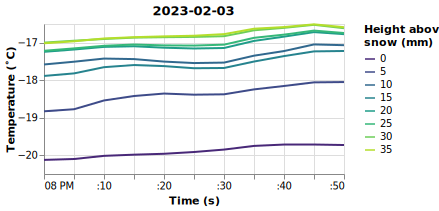

In [371]:
alt.Chart(df).transform_window(
    rolling_mean='mean(value)',
    frame=[1,1],
    groupby=['variable']
).mark_line().encode(
    alt.X('time:T', title="Time (s)"),
    alt.Y('rolling_mean:Q', scale=alt.Scale(zero=False), title="Temperature (˚C)"),
    alt.Color('variable:O', scale = alt.Scale(scheme='viridis'), title=['Height above', 'snow (mm)'])
).properties(width=300, height=150, title = df['time'].dt.date.iloc[0].strftime("%Y-%m-%d"))

/tmp/ipykernel_73495/2036651066.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  src = df.groupby("variable").mean().reset_index()


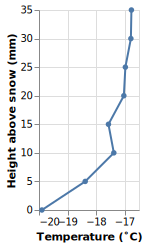

In [372]:
src = df.groupby("variable").mean().reset_index()
alt.Chart(src).mark_line(point=True).encode(
    alt.X('value:Q', sort='-y', title='Temperature (˚C)'),
    alt.Y('variable:Q', title='Height above snow (mm)')
).properties(width=100, height=200)

In [373]:
temp_profile_5mm = src.copy()

# Extract an overlapping timespan from the SoS dataset and the Temperature variables.

In [374]:
df

,time_seconds,side,variable,value,time
0,0,low,0,-20.178085,2023-02-03 20:00:00
0,0,high,5,-18.936782,2023-02-03 20:00:00
11,0,low,10,-17.674011,2023-02-03 20:00:00
11,0,high,15,-17.972473,2023-02-03 20:00:00
22,0,low,20,-17.274871,2023-02-03 20:00:00
...,...,...,...,...,...
21,50,high,15,-17.230407,2023-02-03 20:00:50
32,50,low,20,-16.758422,2023-02-03 20:00:50
32,50,high,25,-16.712585,2023-02-03 20:00:50
43,50,low,30,-16.613983,2023-02-03 20:00:50


In [375]:
kps_data = tidy_df_5Min[
    tidy_df_5Min.measurement.isin([
        'temperature', 'surface temperature', 'snow temperature', 
    ])
][
    (tidy_df_5Min.time == '2023-02-03 20:02:30') | (tidy_df_5Min.time == '2023-02-03 19:57:30')
]

/tmp/ipykernel_73495/3572387566.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kps_data = tidy_df_5Min[


# Figure out which sensors are above the snow...if there are any...

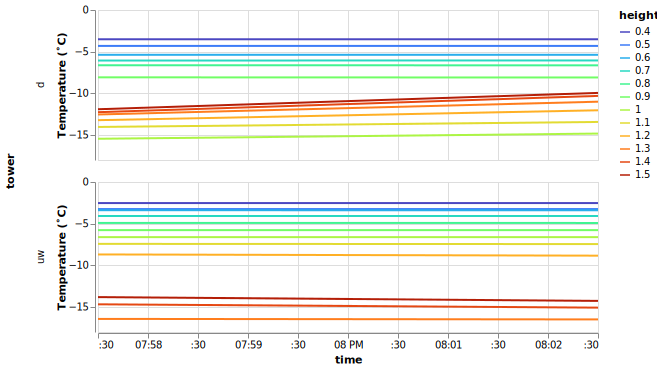

In [376]:
alt.Chart(
    kps_data.query("measurement == 'snow temperature'")
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q", title='Temperature (˚C)'),
    alt.Color("height:O").scale(scheme='turbo'),
    alt.Row("tower:N")
).properties(width=500, height = 150)

/tmp/ipykernel_73495/4068192915.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().reset_index()


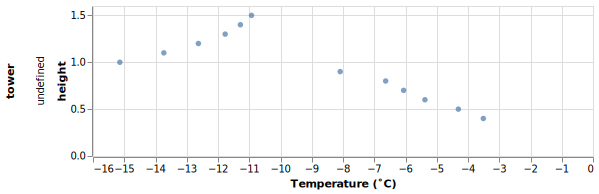

In [377]:
kps_snow_src = kps_data.query("tower == 'd'").query(
    "measurement == 'snow temperature'"
).groupby(
    ["variable", 'height', 'measurement']
).mean().reset_index()

alt.Chart(
    kps_snow_src
).mark_circle().encode(
    alt.X("value:Q").sort("-y").title('Temperature (˚C)'),
    alt.Y("height:Q"),
    # alt.Color("height:O").scale(scheme='turbo'),
    alt.Row("tower:N")
).properties(width=500, height = 150)

In snow temp sensors 1.0 and above are in the air. Sensors 0.9 and below are in snow. assume snow height of .95m

# Combine 3 datasets

In [382]:
temp_profile_5mm = temp_profile_5mm.assign(height = temp_profile_5mm['variable']*.001)

In [383]:
temp_profile_10cm = kps_snow_src.query("height >= 1")
temp_profile_10cm['height'] = temp_profile_10cm['height'] - 0.95

/tmp/ipykernel_73495/2522061055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_profile_10cm['height'] = temp_profile_10cm['height'] - 0.95


In [412]:
temp_profile_1m_and_surf = kps_data[
    kps_data.measurement.isin(['temperature', 'surface temperature'])
].query("tower == 'c'")

temp_profile_1m_and_surf = temp_profile_1m_and_surf.groupby(
    ["variable", "height", "measurement"]
).mean().reset_index()

temp_profile_1m_and_surf['height'] = temp_profile_1m_and_surf['height'].apply(
    lambda h: h if h == 0 else h - 0.95
)

/tmp/ipykernel_73495/471428878.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ).mean().reset_index()


In [431]:
temps_combined = pd.concat([
    temp_profile_5mm.assign(measurement = "Thermistor harp")[['height', 'value', 'measurement']],
    temp_profile_10cm.assign(measurement = 'Thermistor')[['height', 'value', 'measurement']],
    temp_profile_1m_and_surf[['height', 'value', 'measurement']]
])
temps_combined.measurement = temps_combined.measurement.replace("temperature", "Aspirated hygrothermometer")
temps_combined.measurement = temps_combined.measurement.replace("surface temperature", "Pyrgeometer")

In [432]:
temps_combined.sort_values("height")

,height,value,measurement
0,0.000,-19.899076,Thermistor harp
19,0.000,-21.990974,Pyrgeometer
1,0.005,-18.382775,Thermistor harp
2,0.010,-17.380759,Thermistor harp
3,0.015,-17.569309,Thermistor harp
4,0.020,-17.030241,Thermistor harp
5,0.025,-16.977131,Thermistor harp
6,0.030,-16.783877,Thermistor harp
7,0.035,-16.765439,Thermistor harp
6,0.050,-15.140746,Thermistor


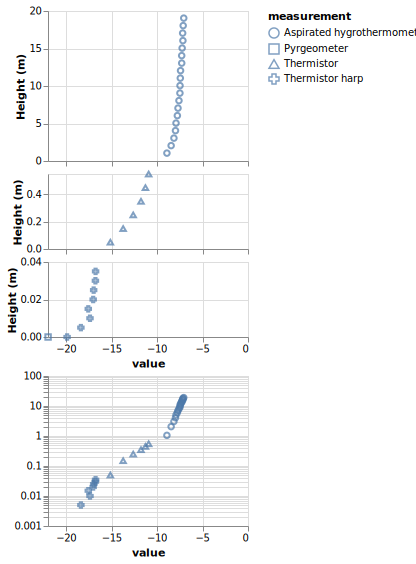

In [436]:
base = alt.Chart(temps_combined).mark_point().encode(
    alt.Y("height:Q", title='Height (m)'),
    alt.Shape("measurement:N")
)
((
    base.transform_filter(
        alt.datum.height > 1
    ).encode(
        alt.X("value", title='').sort("-y").axis(labels=False),
    ).properties(
        width = 200, 
        height = 150
    ) & \
    base.transform_filter(
        (alt.datum.height < 1) & (alt.datum.height >= 0.05)
    ).encode(
        alt.X("value", title='').sort("-y").axis(labels=False),
    ).properties(
        width = 200, 
        height = 75
    ) & \
    base.transform_filter(
        alt.datum.height < 0.05
    ).encode(
        alt.X("value").sort("-y"),
    ).properties(
        width = 200, 
        height = 75
    )
) & alt.Chart(
    temps_combined.query('height > 0')
).mark_point().encode(
    alt.X("value").sort("-y"),
    alt.Y("height:Q", title='').scale(type='log'),
    alt.Shape("measurement:N")
).properties(
        width = 200, 
        height = 150
    )).configure_concat(
        spacing = 0
).resolve_scale(
    shape='shared', 
    x='shared'
).configure_legend(labelLimit=300)